### 학습목표
1. 푸쉬 노티피케이션 타임 의사 결정 하기

In [1]:
import numpy as np
import pandas as pd
# seaborn
import seaborn as sns
COLORS = sns.color_palette()

%matplotlib inline

In [2]:
def plot_bar(df, xlabel, ylabel, title, figsize=(20, 10), color=COLORS[-1], rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=10)
    plot.set_ylabel(ylabel, fontsize=10)
    plot.set_title(title, fontsize=12)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [3]:
dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32
}
retail = pd.read_csv('./OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 쿠폰 발송을 할때, push를 언제 보내는게 좋을까?
 - 고객에게 쿠폰 발송을 한다고 기획하고, 회의를 한다고 가정해보겠습니다. 
  - A: 쿠폰을 언제보내는게 좋을까요?
  - B: 아침에 출퇴근 시간에 보내는게 좋을까요?
  - C: 점심 먹고 졸린데 그때 보내보죠?
  - D: 흠 자기전에 스마트폰 많이 하던데 그때는 어떨까요?
  - A: 그러면 평균 시간을 내볼까요?
  - K: 아 **데이터**를 확인해보는게 맞지 않을까요? 언제 고객이 주로 주문을 하는지? 


 - 위에서 처럼 실제로 회의를 하다보면 의사결정이 본인/주변의 경험에 의해서 이뤄지는 것을 많이 볼 수 있습니다. 
 - 주문이 이뤄지는 시간을 고려하지 않고 막무가내로 보낸다면 아무 의미가 없고, 추후 같은 이벤트 발생시에도 판단 근거가 없게 됨
 - 현상태에서는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단
   - 1. 데이터로 파악
   - 2. 가설 제시
   - 3. 가설 검증
   - 4. 1-3 반복
 - 시간(hour, minute)과 주로 관련되기 때문에 역시 InvoiceDate가 중요한 feature
   

In [4]:
order_by_hour = retail.set_index('InvoiceDate').groupby(lambda date:date.hour).count()
order_by_hour['InvoiceNo']

InvoiceDate
6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: InvoiceNo, dtype: int64

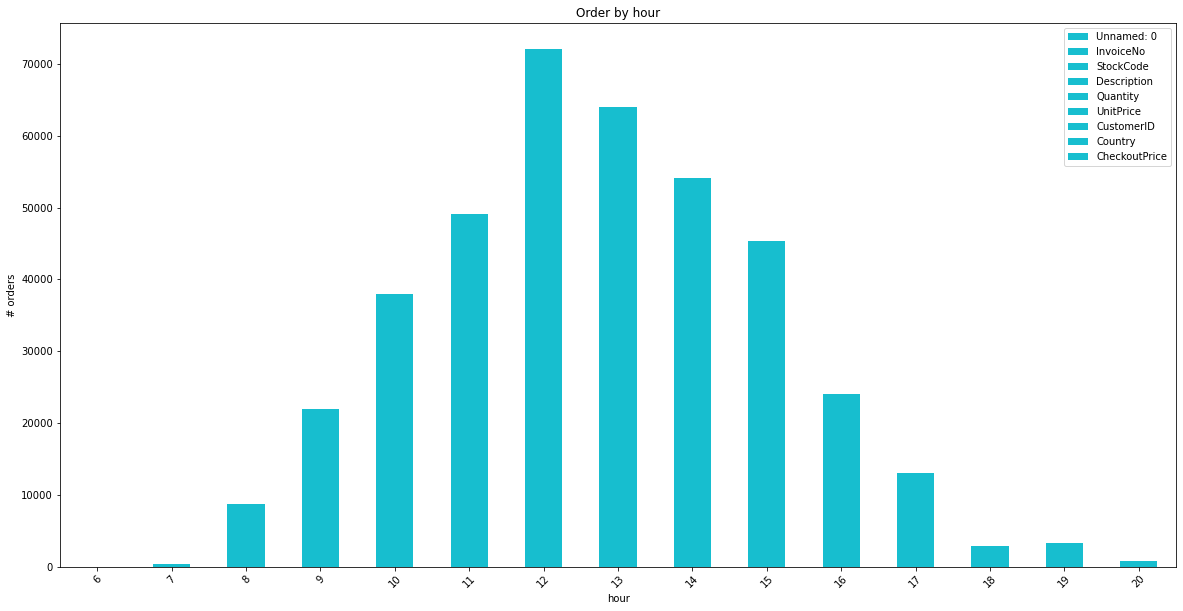

In [5]:
plot_bar(order_by_hour, 'hour', '# orders', 'Order by hour')

In [6]:
def half_an_hour(date):
    minute = ':00'
    if date.minute > 30:
        minute = ':30'
    hour = str(date.hour)
    if date.hour < 10:
        hour = '0' + hour
        
    return hour + minute

In [7]:
order_by_hour_half = retail.set_index('InvoiceDate').groupby(half_an_hour).count()['InvoiceNo']

In [8]:
order_by_hour_half

InvoiceDate
06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: InvoiceNo, dtype: int64

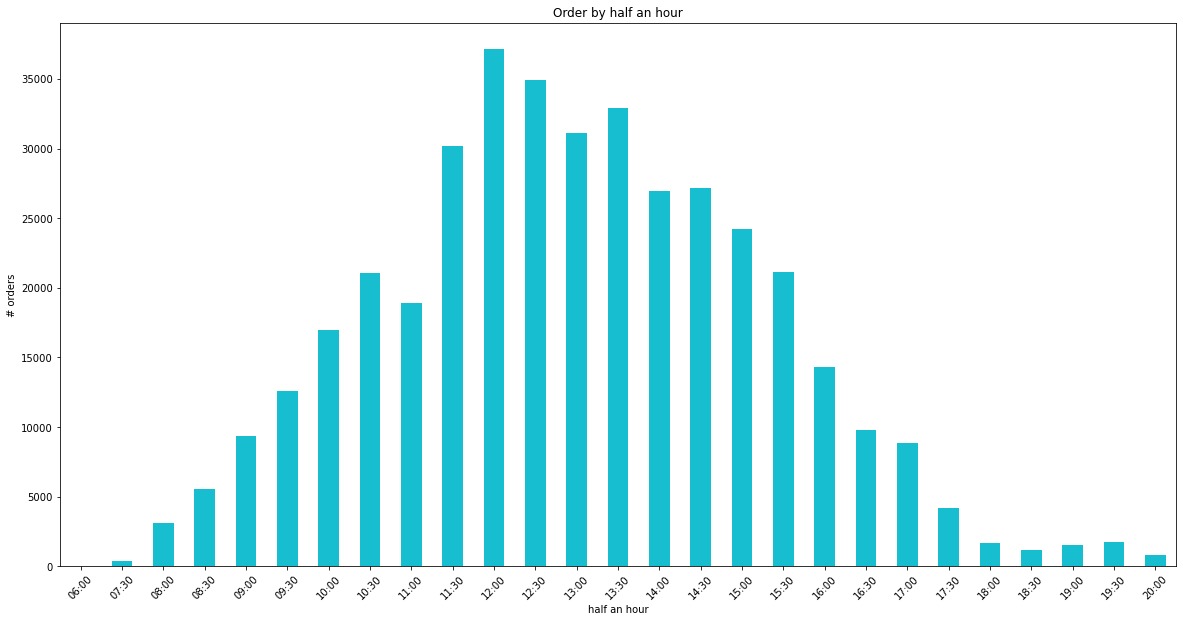

In [9]:
plot_bar(order_by_hour_half, 'half an hour', '# orders', 'Order by half an hour')

In [12]:
order_by_hour_half / order_by_hour_half.sum()

InvoiceDate
06:00    0.000003
07:30    0.000953
08:00    0.007904
08:30    0.013936
09:00    0.023534
09:30    0.031617
10:00    0.042600
10:30    0.052897
11:00    0.047564
11:30    0.075798
12:00    0.093429
12:30    0.087691
13:00    0.078241
13:30    0.082675
14:00    0.067753
14:30    0.068261
15:00    0.060890
15:30    0.053136
16:00    0.035980
16:30    0.024562
17:00    0.022341
17:30    0.010511
18:00    0.004310
18:30    0.003049
19:00    0.003855
19:30    0.004491
20:00    0.002016
Name: InvoiceNo, dtype: float64

#### 개인화된 push notification
- 아마존을 필두로, 개인화(personalization)하여 맞춤으로 사용자마다 최적의 솔루션을 찾는 것이 트렌드가 됨
- 사용자별로 소비의 패턴이 다를 수 있기 때문에, 가장 많이 구매한 시간대를 찾아서 해당 시간대에 쿠폰 발송

#### 사용자별 각 시간별 주문량 계산하기

In [16]:
order_count_by_hour = retail.set_index('InvoiceDate').groupby(['CustomerID', lambda date:date.hour]).count()['StockCode']
order_count_by_hour

CustomerID  InvoiceDate
12346       10              1
12347       8              22
            10             24
            12             47
            13             18
                           ..
18283       15              1
            16             56
            19             87
18287       9               3
            10             67
Name: StockCode, Length: 11205, dtype: int64

In [17]:
order_count_by_hour.loc[12347]

InvoiceDate
8     22
10    24
12    47
13    18
14    60
15    11
Name: StockCode, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
- 가장 많은 주문량을 보인 시간을 계산

In [20]:
idx = order_count_by_hour.groupby('CustomerID').idxmax()
idx

CustomerID
12346    (12346, 10)
12347    (12347, 14)
12348    (12348, 19)
12349     (12349, 9)
12350    (12350, 16)
            ...     
18280     (18280, 9)
18281    (18281, 10)
18282    (18282, 13)
18283    (18283, 14)
18287    (18287, 10)
Name: StockCode, Length: 4338, dtype: object

#### 해당 시간 indexing

In [23]:
result = order_count_by_hour.loc[idx]
result = order_count_by_hour.loc[idx]

CustomerID  InvoiceDate
12346       10               1
12347       14              60
12348       19              17
12349       9               73
12350       16              17
                          ... 
18280       9               10
18281       10               7
18282       13               7
18283       14             201
18287       10              67
Name: StockCode, Length: 4338, dtype: int64

In [30]:
result.reset_index().groupby('InvoiceDate').groups

{7: [73, 269, 319, 344, 375, 893, 1667, 2317], 8: [46, 58, 87, 126, 172, 179, 187, 260, 278, 279, 282, 292, 306, 347, 399, 429, 496, 503, 526, 533, 549, 552, 651, 671, 747, 755, 784, 792, 800, 803, 806, 821, 838, 877, 883, 920, 944, 947, 951, 954, 1008, 1093, 1106, 1120, 1138, 1172, 1173, 1217, 1251, 1397, 1422, 1424, 1436, 1472, 1512, 1616, 1621, 1666, 1668, 1678, 1687, 1734, 1759, 1761, 1774, 1791, 1815, 1827, 1846, 1859, 1895, 1900, 1903, 1996, 2018, 2023, 2054, 2085, 2108, 2117, 2167, 2172, 2253, 2380, 2383, 2403, 2404, 2417, 2427, 2462, 2464, 2643, 2749, 2776, 2781, 2896, 2936, 2949, 3021, 3130, ...], 9: [3, 9, 26, 30, 33, 35, 37, 48, 60, 66, 75, 84, 86, 90, 100, 106, 107, 121, 127, 135, 138, 142, 144, 146, 154, 159, 181, 199, 230, 240, 264, 265, 267, 277, 280, 286, 294, 298, 328, 333, 336, 342, 343, 352, 362, 366, 385, 402, 421, 459, 470, 475, 478, 482, 483, 509, 517, 519, 574, 603, 615, 630, 636, 642, 644, 691, 701, 706, 707, 746, 749, 752, 764, 770, 781, 783, 818, 825, 829, 844